In [1]:
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as torch_models
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
from PIL import Image
from torch.autograd import Variable
from numpy import linalg
import math
from math import cos, sqrt, pi
import time
import copy
import csv
import pandas as pd
from tqdm import tqdm
from torchvision.models import ResNet50_Weights

/Users/mauriciosightman/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Getting Data

#### Download Image Net

In [ ]:
!wget https://image-net.org/data/ILSVRC/2012/ILSVRC2012_img_val.tar

In [ ]:
!mkdir ./ILSVRC2012_img_val
!tar -xf ILSVRC2012_img_val.tar -C ./ILSVRC2012_img_val

### Download Flowers 102

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz

In [54]:
!mkdir ./Flowers102
!tar -xf 102flowers.tgz -C ./Flowers102

### Get images to test algorithm

In [49]:
from collections import defaultdict
import random

In [50]:
def get_random_images(input_txt_path, output_csv_path):
    # Lendo o arquivo TXT
    df = pd.read_csv(input_txt_path, sep=' ', header=None, names=['image_name', 'class'])

    # Criando um dicionário para armazenar as imagens por classe
    images_per_class = defaultdict(list)
    for index, row in df.iterrows():
        images_per_class[row['class']].append(row['image_name'])

    # Embaralhando as chaves das classes para seleção aleatória
    classes = list(images_per_class.keys())
    random.shuffle(classes)

    # Inicializando a lista para armazenar as imagens selecionadas e suas classes
    selected_images_and_classes = []

    for i in range(TOTAL_IMAGES_TO_USE):
        class_id = classes[i % len(classes)]
        image_name = images_per_class[class_id][i % len(images_per_class[class_id])]
        selected_images_and_classes.append((image_name, class_id))

    # Criando um DataFrame com as imagens selecionadas e suas classes
    df_selected = pd.DataFrame(selected_images_and_classes, columns=['image_name', 'class'])

    # Salvando o DataFrame em um arquivo CSV
    df_selected.to_csv(output_csv_path, index=False)

    print(f"Arquivo '{output_csv_path}' salvo com sucesso.")
    print(f"Total de imagens selecionadas: {len(df_selected)}")
    print(f"Total de classes cobertas: {df_selected['class'].nunique()}")

    # Retornando o DataFrame para visualização
    return df_selected


In [2]:
TOTAL_IMAGES_TO_USE = 175

In [ ]:
# Image Net
df_image_net = get_random_images('val.txt', 'val_used_imagens.csv')

In [ ]:
df_image_net.groupby('class').size().reset_index(name='counts').sort_values('counts', ascending=False)

In [ ]:
# Flowers 102
df_flowers = get_random_images('val_102flowers.txt', 'val_flowers_used_imagens.csv')

In [ ]:
df_flowers.groupby('class').size().reset_index(name='counts').sort_values('counts', ascending=False)

### Load images into /data

In [51]:
import shutil

In [52]:
def move_images(csv_file_path, source_directory, target_directory):
    # Lendo o arquivo CSV para obter os nomes das imagens
    df = pd.read_csv(csv_file_path)

    # Iterando sobre os nomes das imagens no DataFrame
    for image_name in df['image_name']:
        source_path = os.path.join(source_directory, image_name)
        target_path = os.path.join(target_directory, image_name)

        # Movendo a imagem
        try:
            shutil.move(source_path, target_path)
        except FileNotFoundError:
            print(f"Imagem {image_name} não encontrada em {source_directory}.")
        except Exception as e:
            print(f"Erro ao mover {image_name}: {e}")


In [ ]:
# Image net
# ONLY RUN THIS CODE ONE TIME
!mkdir ./data/ILSVRC2012_img_val
# move_images('val_used_imagens.csv', './ILSVRC2012_img_val', './data/ILSVRC2012_img_val')

In [55]:
# Flowers 102
# ONLY RUN THIS CODE ONE TIME
!mkdir ./data/Flowers102
move_images('val_flowers_used_imagens.csv', './Flowers102/jpg', './data/Flowers102')

mkdir: ./data/Flowers102: File exists


Imagem image_03199.jpg não encontrada em ./Flowers102/jpg.


## General Functions

In [3]:
torch.manual_seed(992)
torch.cuda.manual_seed(992)
np.random.seed(992)

In [4]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [23]:
def dct(x, y, v, u, n):
    # Normalisation
    def alpha(a):
        if a == 0:
            return sqrt(1.0 / n)
        else:
            return sqrt(2.0 / n)

    return alpha(u) * alpha(v) * cos(((2 * x + 1) * (u * pi)) / (2 * n)) * cos(((2 * y + 1) * (v * pi)) / (2 * n))


def generate_2d_dct_basis(sub_dim=75):
    n = 224  # Assume square image, so we don't have different xres and yres

    # We can get different frequencies by setting u and v
    # Here, we have a max u and v to loop over and display
    # Feel free to adjust
    maxU = sub_dim
    maxV = sub_dim

    dct_basis = []
    for u in range(0, maxU):
        for v in range(0, maxV):
            basisImg = np.zeros((n, n))
            for y in range(0, n):
                for x in range(0, n):
                    basisImg[y, x] = dct(x, y, v, u, max(n, maxV))
            dct_basis.append(basisImg)
    dct_basis = np.mat(np.reshape(dct_basis, (maxV*maxU, n*n))).transpose()
    np.save('2d_dct_basis_{}.npy'.format(sub_dim), dct_basis)
    return dct_basis


In [22]:
def get_label(x):
    s = x.split(' ')
    label = ''
    for l in range(1, len(s)):
        label += s[l] + ' '

    return label

def clip_image_values(x, minv, maxv):
    x = torch.max(x, minv)
    x = torch.min(x, maxv)
    return x


def valid_bounds(img, delta=255):

    im = copy.deepcopy(np.asarray(img))
    im = im.astype(int)

    # General valid bounds [0, 255]
    valid_lb = np.zeros_like(im)
    valid_ub = np.full_like(im, 255)

    # Compute the bounds
    lb = im - delta
    ub = im + delta

    # Validate that the bounds are in [0, 255]
    lb = np.maximum(valid_lb, np.minimum(lb, im))
    ub = np.minimum(valid_ub, np.maximum(ub, im))

    # Change types to uint8
    lb = lb.astype(np.uint8)
    ub = ub.astype(np.uint8)

    return lb, ub

In [24]:
def inv_tf(x, mean, std):
    x_clone = x.copy()

    for i in range(len(mean)):

        x_clone[i] = np.multiply(x_clone[i], std[i], dtype=np.float32)
        x_clone[i] = np.add(x_clone[i], mean[i], dtype=np.float32)

    x_clone = np.swapaxes(x_clone, 0, 2)
    x_clone = np.swapaxes(x_clone, 0, 1)

    return x_clone

In [25]:
def is_adversarial(target_model, given_image, orig_label):

    predict_label = torch.argmax(target_model.forward(Variable(given_image, requires_grad=True)).data).item()

    return predict_label != orig_label

In [26]:
def find_random_adversarial(target_model, orig_label, image, lb, ub):

    num_calls = 1

    step = 0.02
    perturbed = image.clone()

    while is_adversarial(target_model, perturbed, orig_label) == 0:

        pert = torch.randn([1,3,224,224])
        pert = pert.to(device)

        perturbed = image + num_calls*step* pert
        perturbed = clip_image_values(perturbed, lb, ub)
        perturbed = perturbed.to(device)
        num_calls += 1

    return perturbed, num_calls

In [27]:
def bin_search(target_model, orig_label, x_0, x_random, tol):

    num_calls = 0
    adv = x_random
    cln = x_0

    while True:

        mid = (cln + adv) / 2.0
        num_calls += 1

        if is_adversarial(target_model, mid, orig_label):
            adv = mid
        else:
            cln = mid

        if torch.norm(adv-cln).cpu().numpy()<tol:
            break

    return adv, num_calls

In [28]:
def black_grad_batch(target_model, x_boundary, q_max, sigma, random_noises, batch_size, original_label, sub_basis_torch):

    grad_tmp = [] # estimated gradients in each estimate_batch
    z = []        # sign of grad_tmp
    outs = []
    num_batchs = math.ceil(q_max/batch_size)
    last_batch = q_max - (num_batchs-1)*batch_size
    
    if torch.cuda.is_available():
        EstNoise = SubNoise(batch_size, sub_basis_torch).cuda()
    else:
        EstNoise = SubNoise(batch_size, sub_basis_torch)

    all_noises = []
    for j in range(num_batchs):
        if j == num_batchs-1:
            if torch.cuda.is_available():
                EstNoise_last = SubNoise(last_batch, sub_basis_torch).cuda()
            else:
                EstNoise_last = SubNoise(last_batch, sub_basis_torch)

            current_batch = EstNoise_last()
            current_batch_np = current_batch.cpu().numpy()
            noisy_boundary = [x_boundary[0,:,:,:].cpu().numpy()]*last_batch +sigma*current_batch.cpu().numpy()

        else:
            current_batch = EstNoise()
            current_batch_np = current_batch.cpu().numpy()
            noisy_boundary = [x_boundary[0,:,:,:].cpu().numpy()]*batch_size +sigma*current_batch.cpu().numpy()

        all_noises.append(current_batch_np)

        noisy_boundary_tensor = torch.tensor(noisy_boundary).to(device)

        predict_labels = torch.argmax(target_model.forward(noisy_boundary_tensor),1).cpu().numpy().astype(int)


        outs.append(predict_labels)
    all_noise = np.concatenate(all_noises, axis=0)
    outs = np.concatenate(outs, axis=0)

    acc = np.mean(outs == original_label)
    for i, predict_label in enumerate(outs):
        if predict_label == original_label:
            z.append(1)
            grad_tmp.append(all_noise[i])
        else:
            z.append(-1)
            grad_tmp.append(-all_noise[i])

    grad = -(1/q_max)*sum(grad_tmp)

    grad_f = torch.tensor(grad).to(device)[None, :,:,:]

    return grad_f, sum(z), acc

In [29]:
def go_to_boundary(target_model, orig_label, x_0, grad, x_b, dist, lb, ub):

    epsilon = 5

    num_calls = 1
    perturbed = x_0

    if dist == 'l1' or dist == 'l2':

        grads = grad


    if dist == 'linf':

        grads = torch.sign(grad)/torch.norm(grad)



    while is_adversarial(target_model, perturbed, orig_label) == 0:

        perturbed = x_0 + (num_calls*epsilon* grads[0])
        perturbed = clip_image_values(perturbed, lb, ub)

        num_calls += 1

        if num_calls > 100:
            print('falied ... ')
            break
        print
    return perturbed, num_calls, epsilon*num_calls

In [30]:
def load_sub_basis(search_space, sub_dim=75, verbose_control='Yes'):
  if search_space == 'sub':

    if verbose_control == 'Yes':
      print('Check if DCT basis available ...')

    path = './2d_dct_basis_{}.npy'.format(sub_dim)
    if os.path.exists(path):
        if verbose_control == 'Yes':
          print('Yes, we already have it ...')
        sub_basis = np.load('2d_dct_basis_{}.npy'.format(sub_dim)).astype(np.float32)
    else:
        print('Generating dct basis ......')
        sub_basis = generate_2d_dct_basis(sub_dim).astype(np.float32)
        print('Done!\n')

    if torch.cuda.is_available():
      sub_basis_torch = torch.from_numpy(sub_basis).cuda()
    else:
      sub_basis_torch = torch.from_numpy(sub_basis)

    return sub_basis_torch

In [31]:
def GeoDA(target_model, x_b, x_0, iteration, q_opt, dist, image_fb, orig_label, lb, ub, query_rnd, grad_estimator_batch_size=40, verbose_control='Yes', sigma=0.0002, tol=0.0001, search_space='sub', q_max=None, image_name=None):

    # Load sub basis
    sub_basis_torch = load_sub_basis(search_space, verbose_control=verbose_control)

    iteration_data = []  # List to store iteration data
    q_num = 0
    grad = 0

    for i in range(iteration):

        t1 = time.time()
        random_vec_o = torch.randn(q_opt[i],3,224,224)

        grad_oi, ratios, acc = black_grad_batch(target_model, x_b, q_opt[i], sigma, random_vec_o, grad_estimator_batch_size , orig_label, sub_basis_torch)
        q_num = q_num + q_opt[i]
        grad = grad_oi + grad
        x_adv, qs, eps = go_to_boundary(target_model, orig_label, x_0, grad, x_b, dist, lb, ub)
        q_num = q_num + qs
        x_adv, bin_query = bin_search(target_model, orig_label, x_0, x_adv, tol)


        q_num = q_num + bin_query

        x_b = x_adv

        t2 = time.time()
        x_adv_inv = inv_tf(x_adv.cpu().numpy()[0,:,:,:].squeeze(), mean, std)

        if dist == 'l1' or dist == 'l2':
            dp = 'l2'
            norm_p = linalg.norm(x_adv_inv-image_fb)


        if dist == 'linf':
            dp = dist

            norm_p = np.max(abs(x_adv_inv-image_fb))

        adv_label = torch.argmax(target_model.forward(Variable(x_adv, requires_grad=True)).data).item()
        iteration_data.append(('geoda', i, dist, search_space, norm_p, t2 - t1, q_num + query_rnd, q_max, image_name, orig_label, adv_label, acc))

        if verbose_control == 'Yes':
            message = ' (took {:.5f} seconds)'.format(t2 - t1)
            print('iteration -> ' + str(i) + str(message) + '     -- ' + dp + ' norm is -> ' + str(norm_p))

    with open('log.csv', 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(iteration_data)


    x_adv = clip_image_values(x_adv, lb, ub)

    return x_adv, q_num, grad

In [32]:
def opt_query_iteration(Nq, T, eta):

    coefs=[eta**(-2*i/3) for i in range(0,T)]
    coefs[0] = 1*coefs[0]

    sum_coefs = sum(coefs)
    opt_q=[round(Nq*coefs[i]/sum_coefs) for i in range(0,T)]

    if opt_q[0]>80:
        T = T + 1
        opt_q, T = opt_query_iteration(Nq, T, eta)
    elif opt_q[0]<50:
        T = T - 1

        opt_q, T = opt_query_iteration(Nq, T, eta)

    return opt_q, T

def uni_query(Nq, T, eta):

    opt_q=[round(Nq/T) for i in range(0,T)]


    return opt_q

In [5]:
def load_image(image, shape=(224, 224), data_format='channels_last'):

    assert len(shape) == 2
    assert data_format in ['channels_first', 'channels_last']

    image = image.resize(shape)
    image = np.asarray(image, dtype=np.float32)

    image = image[:, :, :3]
    assert image.shape == shape + (3,)
    if data_format == 'channels_first':
        image = np.transpose(image, (2, 0, 1))
    return image

In [34]:
class SubNoise(nn.Module):
    """given subspace x and the number of noises, generate sub noises"""
    # x is the subspace basis
    def __init__(self, num_noises, x):
        self.num_noises = num_noises
        self.x = x
        super(SubNoise, self).__init__()

    def forward(self):


        r = torch.zeros([224 ** 2, 3*self.num_noises], dtype=torch.float32)
        if torch.cuda.is_available():
            noise = torch.randn([self.x.shape[1], 3*self.num_noises], dtype=torch.float32).cuda()
        else:
            noise = torch.randn([self.x.shape[1], 3*self.num_noises], dtype=torch.float32)
            
        sub_noise = torch.transpose(torch.mm(self.x, noise), 0, 1)
        r = sub_noise.view([ self.num_noises, 3, 224, 224])

        r_list = r
        return r_list

## GeoDA

In [ ]:
def run_geoDa(target_model, image_path, true_label, Q_max=1000, dist='l2', tol=0.0001, mu=0.6, search_space='sub', grad_estimator_batch_size=40, verbose_control='Yes'):

  # Load image and tested
  im_orig = Image.open(image_path)
  im_sz = 224

  if im_orig.mode != 'RGB':
      im_orig = im_orig.convert('RGB')

  im_orig = transforms.Compose([transforms.Resize((im_sz, im_sz))])(im_orig)

  image_fb = load_image(im_orig, data_format='channels_last')
  image_fb = image_fb / 255.  # because our model expects values in [0, 1]

  # Bounds for Validity and Perceptibility
  delta = 255
  lb, ub = valid_bounds(im_orig, delta)

  # Transform data
  im = transforms.Compose([
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean = mean,
                          std = std)])(im_orig)

  lb = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])(lb)
  ub = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])(ub)

  lb = lb[None, :, :, :].to(device)
  ub = ub[None, :, :, :].to(device)

  x_0 = im[None, :, :, :].to(device)

  # Test image in model
  orig_label = torch.argmax(target_model.forward(Variable(x_0, requires_grad=True)).data).item()

  if true_label != int(orig_label):
      if verbose_control == 'Yes':
        print('Already missclassified... Lets try another one!')
        print(f'Predicted label: {orig_label}')
      with open('log.csv', 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerows([('geoda', None, dist, search_space, None, None, None, Q_max, image_path, true_label, orig_label, None)])
      return


  x0_inverse = inv_tf(x_0.cpu().numpy()[0,:,:,:].squeeze(), mean, std)
  dif_norm = linalg.norm(x0_inverse-image_fb)


  ###################################


  x_random, query_random_1 = find_random_adversarial(target_model, orig_label, x_0, lb, ub)

  x_rnd_inverse = inv_tf(x_random.cpu().numpy()[0,:,:,:].squeeze(), mean, std)


  # Binary search
  x_boundary, query_binsearch_2 = bin_search(target_model, orig_label, x_0, x_random, tol)
  x_b = x_boundary


  x_bin_inverse = inv_tf(x_boundary.cpu().numpy()[0,:,:,:].squeeze(), mean, std)


  x_rnd_BA = np.swapaxes(x_bin_inverse, 0, 2)
  x_rnd_BA = np.swapaxes(x_rnd_BA, 1, 2)

  query_rnd = query_binsearch_2 + query_random_1


  ###################################
  # Run over iterations

  iteration = round(Q_max/500)
  q_opt_it = int(Q_max  - (iteration)*25)
  q_opt_iter, iterate = opt_query_iteration(q_opt_it, iteration, mu )
  q_opt_it = int(Q_max  - (iterate)*25)
  q_opt_iter, iterate = opt_query_iteration(q_opt_it, iteration, mu )
  if verbose_control == 'Yes':
    print('#################################################################')
    print('Start: The GeoDA will be run for:' + ' Iterations = ' + str(iterate) + ', Query = ' + str(Q_max) + ', Norm = ' + str(dist)+ ', Space = ' + str(search_space) )
    print('#################################################################')


  t3 = time.time()
  x_adv, query_o, _ = GeoDA(target_model, x_b, x_0, iterate, q_opt_iter, dist, image_fb, orig_label, lb, ub, query_rnd,
                                   grad_estimator_batch_size=grad_estimator_batch_size, search_space=search_space,
                                   q_max=Q_max, image_name=image_path, verbose_control=verbose_control)
  t4 = time.time()
  message = ' took {:.5f} seconds'.format(t4 - t3)
  qmessage = ' with query = ' + str(query_o + query_rnd)

  x_opt_inverse = inv_tf(x_adv.cpu().numpy()[0,:,:,:].squeeze(), mean, std)


  if verbose_control == 'Yes':
    print('#################################################################')
    print('End: The GeoDA algorithm' + message + qmessage )
    print('#################################################################')

  return image_fb, x_adv, x_opt_inverse

## Running GeoDa with Image Net

### Load Model

In [ ]:
# Check for cuda devices
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load a pretrained model
target_model = torch_models.resnet50(pretrained=True)
target_model = target_model.to(device)
target_model.eval()

### Run GeoDa

In [ ]:
df_log = pd.read_csv('log.csv')

In [ ]:
def test_all_validation_test(dist, Q_num, total_load):
  progress_bar = tqdm(total=total_load)
  progress_bar.set_description(f'Dist: {dist}; Q_num: {Q_num}')

  path = './data/ILSVRC2012_img_val'
  for file_name in os.listdir(path):
    # Check if this experiment has already been done
    if df_log[(df_log['distance'] == dist) & (df_log['query_max'] == Q_num) & (df_log['image'] == f'{path}/{file_name}') & (df_log['attack'] == 'geoda')].shape[0] > 0:
      progress_bar.update(1)
      continue

    image_num = int(file_name[15:23])

    ground_truth  = open(os.path.join('val.txt'), 'r').read().split('\n')
    ground_name_label = ground_truth[image_num-1]
    true_label = int(ground_name_label.split()[1])

    run_geoDa(target_model, f'{path}/{file_name}', true_label, Q_max=Q_num, dist=dist, verbose_control='No')

    progress_bar.update(1)

  progress_bar.close()

In [ ]:
dist_avl = ['l2', 'linf']
Q_num_avl = [1000, 5000, 20000]

for dist in dist_avl:
  for Q_num in Q_num_avl:
    test_all_validation_test(dist, Q_num, 100)

## Running GeoDA with Flowers102

### Load model

In [ ]:
# Check for cuda devices
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load a pretrained model
target_model = torch_models.resnet50(pretrained=True)
target_model = target_model.to(device)
target_model.eval()

target_model = torch_models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
total_feats = target_model.fc.in_features
target_model.fc = nn.Linear(total_feats, 102)
target_model.load_state_dict(torch.load('./Resnet50Flowers102/data/102flowers/model_resnet50Flower102.pt'))
target_model = target_model.to(device)
target_model.eval()

### Running

In [ ]:
df_log = pd.read_csv('log.csv')

In [ ]:
def test_all_validation_test(dist, Q_num, total_load):
  progress_bar = tqdm(total=total_load)
  progress_bar.set_description(f'Dist: {dist}; Q_num: {Q_num}')

  path = './data/Flowers102'
  for file_name in os.listdir('./data/Flowers102'):
    # Check if this experiment has already been done
    if df_log[(df_log['distance'] == dist) & (df_log['query_max'] == Q_num) & (df_log['image'] == f'{path}/{file_name}') & (df_log['attack'] == 'geoda')].shape[0] > 0:
      progress_bar.update(1)
      continue

    image_num = int(file_name[6:11])

    ground_truth  = open(os.path.join('val_102flowers.txt'), 'r').read().split('\n')
    class_mapping_list  = open(os.path.join('class_mapping.txt'), 'r').read().split('\n')

    class_mapping = {}
    for item in class_mapping_list:
        pred_c= item.split()
        class_mapping[int(pred_c[1])] = pred_c[0]
    ground_name_label = ground_truth[image_num-1]
    ground_label =  ground_name_label.split()[1]
    true_label = int(class_mapping[int(ground_label)])

    run_geoDa(target_model, f'{path}/{file_name}', true_label, Q_max=Q_num, dist=dist, verbose_control='No')

    progress_bar.update(1)

  progress_bar.close()

In [ ]:
dist_avl = ['l2', 'linf']
Q_num_avl = [1000, 5000, 20000]

for dist in dist_avl:
  for Q_num in Q_num_avl:
    test_all_validation_test(dist, Q_num, 100)

## Other Attacks

In [6]:
import foolbox as fb
from foolbox import PyTorchModel, accuracy
from foolbox.attacks import HopSkipJumpAttack

### HopSkipJumpAttack

#### Image Net

##### Load model

In [ ]:
# Check for cuda devices
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load a pretrained model
target_model = torch_models.resnet50(pretrained=True)
target_model = target_model.to(device)
target_model.eval()

/Users/mauriciosightman/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mauriciosightman/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

##### Running

In [ ]:
# Preprocessamento: especifique como os dados devem ser processados (dependendo do seu modelo)
preprocessing = dict(mean=mean, std=std, axis=-3)

# Envolva o modelo com o FoolBox
fmodel = PyTorchModel(target_model, bounds=(0, 1), preprocessing=preprocessing)

In [ ]:
df_log = pd.read_csv('log.csv')

In [ ]:
def runHopSkipJumpAttack(dist, Q_max, iterations, total_load):
  # Cria o ataque HopSkipJump
  attack = HopSkipJumpAttack(constraint=dist, steps=iterations, max_gradient_eval_steps=int(Q_max/iterations))


  progress_bar = tqdm(total=total_load)
  progress_bar.set_description(f'Dist: {dist}; Q_max: {Q_max}')

  path = './data/ILSVRC2012_img_val'
  for file_name in os.listdir(path):
    # Check if this experiment has already been done
    if df_log[(df_log['distance'] == dist) & (df_log['query_max'] == Q_max) & (df_log['image'] == f'{path}/{file_name}') & (df_log['attack'] == 'HopSkipJumpAttack')].shape[0] > 0:
      progress_bar.update(1)
      continue

    images_path = []
    images_fb = []
    labels = []

    images_path.append(f'{path}/{file_name}')

    image_num = int(file_name[15:23])

    # Carregar labels
    ground_truth  = open(os.path.join('val.txt'), 'r').read().split('\n')
    ground_name_label = ground_truth[image_num-1]
    true_label = int(ground_name_label.split()[1])
    labels.append(true_label)

    # Carregar imagens
    im_orig = Image.open(f'{path}/{file_name}')
    im_orig = transforms.Compose([transforms.Resize((224, 224))])(im_orig)
    if im_orig.mode != 'RGB':
        im_orig = im_orig.convert('RGB')
    image_fb = load_image(im_orig, data_format='channels_first')
    image_fb = image_fb / 255.
    images_fb.append(image_fb)

    # Converter para tensores    
    images_np = np.stack(images_fb)
    images = torch.tensor(images_np).to(device)
    labels = torch.tensor(labels).to(device)
    criterion = fb.criteria.Misclassification(labels)

    # Rodar algoritmo
    t1 = time.time()
    advs, _, is_adv = attack(fmodel, images, criterion, epsilons=0.03)
    t2 = time.time()

    advs_pred = fmodel(advs)
    acc = accuracy(fmodel, advs, labels)

    if dist == 'l1' or dist == 'l2':
      norms_p = fb.distances.l2(images, advs)
    if dist == 'linf':
      norms_p = fb.distances.inf(images, advs)

    with open('log.csv', 'a', newline='') as file:
      writer = csv.writer(file)

      for i in range(len(images_path)):

        image_path = images_path[i]
        adv_label = torch.argmax(advs_pred[i]).item()
        true_label = labels[i].item()
        norm_p = norms_p[i].item()

        writer.writerows([['HopSkipJumpAttack', iterations, dist, None, norm_p, t2 - t1, Q_max, Q_max, image_path, true_label, adv_label, acc]])
      
    progress_bar.update(1)

  progress_bar.close()
  

In [ ]:
dist_avl = ['l2', 'linf']
Q_num_avl = [1000]
intervals = [6, 17, 42]

for dist in dist_avl:
  for i, Q_num in enumerate(Q_num_avl):
    runHopSkipJumpAttack(dist, Q_num, intervals[i], TOTAL_IMAGES_TO_USE)

#### Flowers 102

##### Load Model

In [8]:
# Check for cuda devices
device = 'cuda' if torch.cuda.is_available() else 'cpu'

target_model = torch_models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
total_feats = target_model.fc.in_features
target_model.fc = nn.Linear(total_feats, 102)
target_model.load_state_dict(torch.load('./Resnet50Flowers102/data/102flowers/model_resnet50Flower102.pt'))
target_model = target_model.to(device)
target_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

##### Running

In [9]:
# Preprocessamento: especifique como os dados devem ser processados (dependendo do seu modelo)
preprocessing = dict(mean=mean, std=std, axis=-3)

# Envolva o modelo com o FoolBox
fmodel = PyTorchModel(target_model, bounds=(0, 1), preprocessing=preprocessing)

In [10]:
df_log = pd.read_csv('log.csv')

In [11]:
def runHopSkipJumpAttack(dist, Q_max, iterations, total_load):
  print(f'Step: {dist}, {Q_max}, {iterations}')

  # Crie o ataque HopSkipJump
  attack = HopSkipJumpAttack(constraint=dist, steps=iterations, max_gradient_eval_steps=int(Q_max/iterations))

  progress_bar = tqdm(total=total_load)
  progress_bar.set_description(f'Dist: {dist}; Q_num: {Q_num}')

  path = './data/Flowers102'
  for file_name in os.listdir(path):
    # Check if this experiment has already been done
    if df_log[(df_log['distance'] == dist) & (df_log['query_max'] == Q_max) & (df_log['image'] == f'{path}/{file_name}') & (df_log['attack'] == 'HopSkipJumpAttack')].shape[0] > 0:
      progress_bar.update(1)
      continue

    images_path = []
    images_fb = []
    labels = []

    images_path.append(f'{path}/{file_name}')

    image_num = int(file_name[6:11])

    # Carregar labels
    ground_truth  = open(os.path.join('val_102flowers.txt'), 'r').read().split('\n')
    class_mapping_list  = open(os.path.join('class_mapping.txt'), 'r').read().split('\n')

    class_mapping = {}
    for item in class_mapping_list:
        pred_c= item.split()
        class_mapping[int(pred_c[1])] = pred_c[0]
    ground_name_label = ground_truth[image_num-1]
    ground_label =  ground_name_label.split()[1]
    true_label = int(class_mapping[int(ground_label)])
    labels.append(true_label)

    # Carregar imagens
    im_orig = Image.open(f'{path}/{file_name}')
    im_orig = transforms.Compose([transforms.Resize((224, 224))])(im_orig)
    image_fb = load_image(im_orig, data_format='channels_first')
    image_fb = image_fb / 255.
    images_fb.append(image_fb)


    # Converter para tensores    
    images_np = np.stack(images_fb)
    images = torch.tensor(images_np).to(device)
    labels = torch.tensor(labels).to(device)
    criterion = fb.criteria.Misclassification(labels)


    # Rodar algoritmo
    t1 = time.time()
    advs, _, is_adv = attack(fmodel, images, criterion, epsilons=0.03)
    t2 = time.time()


    advs_pred = fmodel(advs)
    acc = accuracy(fmodel, advs, labels)


    if dist == 'l1' or dist == 'l2':
      norms_p = fb.distances.l2(images, advs)
    if dist == 'linf':
      norms_p = fb.distances.inf(images, advs)


    with open('log.csv', 'a', newline='') as file:
      writer = csv.writer(file)

      for i in range(len(images_path)):

        image_path = images_path[i]
        adv_label = torch.argmax(advs_pred[i]).item()
        true_label = labels[i].item()
        norm_p = norms_p[i].item()

        writer.writerows([['HopSkipJumpAttack', iterations, dist, None, norm_p, t2 - t1, Q_max, Q_max, image_path, true_label, adv_label, acc]])
      
    progress_bar.update(1)

  progress_bar.close()

In [ ]:
dist_avl = ['l2', 'linf']
Q_num_avl = [1000, 5000, 20000]
intervals = [6, 17, 42]

for dist in dist_avl:
  for i, Q_num in enumerate(Q_num_avl):
    runHopSkipJumpAttack(dist, Q_num, intervals[i], TOTAL_IMAGES_TO_USE)

## Analytics

In [358]:
df = pd.read_csv('log.csv')

df['dataset'] = df['image'].apply(lambda x: 'ImageNet' if 'ILSVRC2012_img_val' in x else ('Flowers102' if 'Flowers102' in x else 'outro'))
df = df[df['query_max'] != 10000]
df = df[df['query_max'] != 500]
df = df[df['norm_p'] != 0.0]


In [344]:
# Primeiro, encontrar a máxima 'iteration' para cada grupo definido por 'attack', 'distance' e 'query_max'
max_iteration_per_group = df.groupby(['dataset', 'attack', 'distance', 'query_max'])['iteration'].transform('max')

# Filtrar o DataFrame original para manter apenas as linhas que correspondem ao máximo 'iteration' encontrado
df_max_iterations = df[df['iteration'] == max_iteration_per_group]

# Agora, calcular a mediana de 'norm_p' para os grupos filtrados
median_norm_p = df_max_iterations.groupby(['dataset', 'attack', 'distance', 'query_max'])['norm_p'].median().reset_index()

print(median_norm_p)

       dataset             attack distance  query_max     norm_p
0   Flowers102  HopSkipJumpAttack       l2       1000  10.416317
1   Flowers102  HopSkipJumpAttack       l2       5000   3.388218
2   Flowers102  HopSkipJumpAttack       l2      20000   2.036896
3   Flowers102  HopSkipJumpAttack     linf       1000   0.093573
4   Flowers102  HopSkipJumpAttack     linf       5000   0.089761
5   Flowers102  HopSkipJumpAttack     linf      20000   0.115865
6   Flowers102              geoda       l2       1000   7.462089
7   Flowers102              geoda       l2       5000   3.442279
8   Flowers102              geoda       l2      20000   2.087560
9   Flowers102              geoda     linf       1000   0.032494
10  Flowers102              geoda     linf       5000   0.014018
11  Flowers102              geoda     linf      20000   0.008507
12    ImageNet  HopSkipJumpAttack       l2       1000  17.296208
13    ImageNet  HopSkipJumpAttack       l2       5000   4.104762
14    ImageNet  HopSkipJu

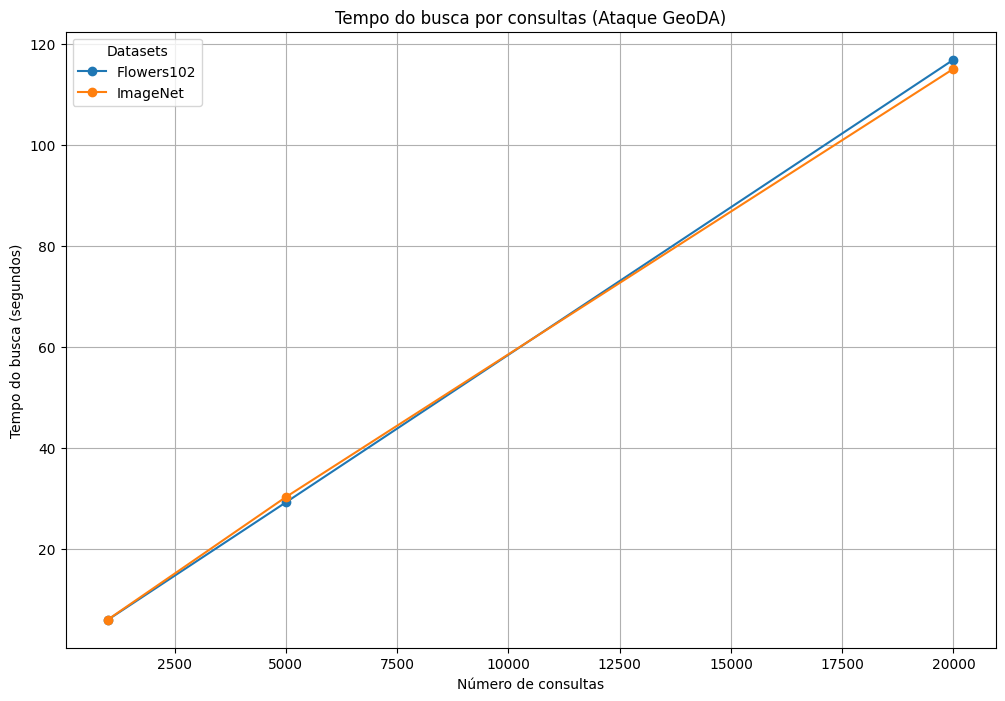

In [345]:

df_geoda = df[(df['attack'] == 'geoda') & (df['distance'] == 'l2')]

grouped = df_geoda.groupby(['image', 'dataset', 'attack', 'query_max']).agg(time_sum=('time', 'sum')).reset_index()

grouped = grouped.groupby(['dataset', 'attack', 'query_max']).agg(time_sum=('time_sum', 'median')).reset_index()

datasets = grouped['dataset'].unique()
plt.figure(figsize=(12, 8))

for dataset in datasets:
    subset = grouped[grouped['dataset'] == dataset]
    # Ordenando pelo 'query_max' para garantir uma linha contínua
    subset = subset.sort_values('query_max')
    plt.plot(subset['query_max'], subset['time_sum'], label=dataset, marker='o')

plt.title('Tempo do busca por consultas (Ataque GeoDA)')
plt.xlabel('Número de consultas')
plt.ylabel('Tempo do busca (segundos)')
plt.legend(title='Datasets')
plt.grid(True)
plt.show()

      dataset  query_max    norm_p
0  Flowers102       1000  7.462089
1  Flowers102       5000  3.442279
2  Flowers102      20000  2.087560
3    ImageNet       1000  7.669284
4    ImageNet       5000  3.688805
5    ImageNet      20000  2.250609


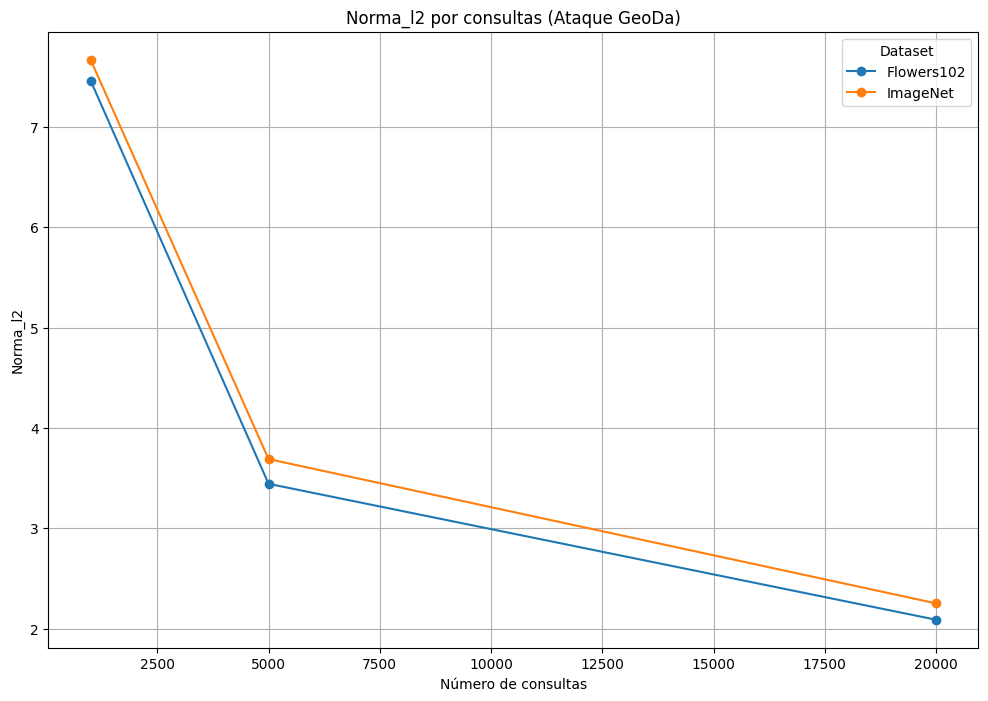

In [346]:
df_geoda = df[(df['attack'] == 'geoda') & (df['distance'] == 'l2')]

grouped = df_geoda.groupby(['image', 'dataset', 'query_max']).agg(norm_p=('norm_p', 'min')).reset_index()

grouped = grouped.groupby(['dataset', 'query_max']).agg(norm_p=('norm_p', 'median')).reset_index()

print(grouped)

datasets = grouped['dataset'].unique()
plt.figure(figsize=(12, 8))

for dataset in datasets:
    subset = grouped[grouped['dataset'] == dataset]
    # Ordenando pelo 'query_max' para garantir uma linha contínua
    subset = subset.sort_values('query_max')
    plt.plot(subset['query_max'], subset['norm_p'], label=dataset, marker='o')

plt.title('Norma_l2 por consultas (Ataque GeoDa)')
plt.xlabel('Número de consultas')
plt.ylabel('Norma_l2')
plt.legend(title='Dataset')
plt.grid(True)
plt.show()

      dataset  query_max     norm_p
0  Flowers102       1000  10.416317
1  Flowers102       5000   3.388218
2  Flowers102      20000   2.036896
3    ImageNet       1000  17.181767
4    ImageNet       5000   3.597367
5    ImageNet      20000   3.086897


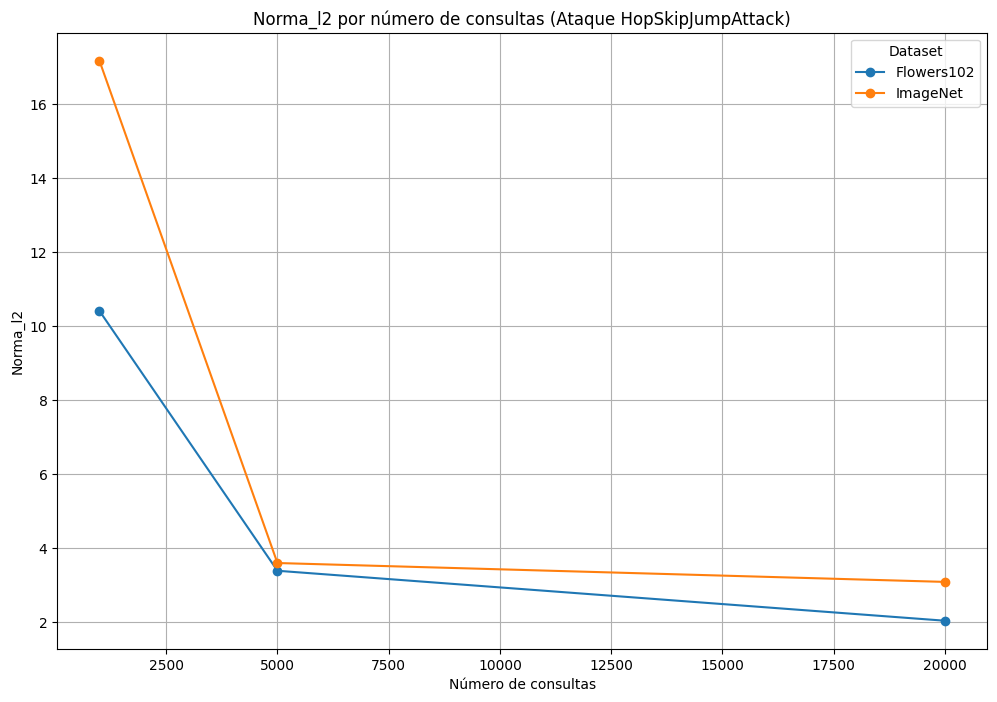

In [347]:
df_geoda = df[(df['attack'] == 'HopSkipJumpAttack') & (df['distance'] == 'l2')]

grouped = df_geoda.groupby(['image', 'dataset', 'query_max']).agg(norm_p=('norm_p', 'min')).reset_index()

grouped = grouped.groupby(['dataset', 'query_max']).agg(norm_p=('norm_p', 'median')).reset_index()

print(grouped)

datasets = grouped['dataset'].unique()
plt.figure(figsize=(12, 8))

for dataset in datasets:
    subset = grouped[grouped['dataset'] == dataset]
    # Ordenando pelo 'query_max' para garantir uma linha contínua
    subset = subset.sort_values('query_max')
    plt.plot(subset['query_max'], subset['norm_p'], label=dataset, marker='o')

plt.title('Norma_l2 por número de consultas (Ataque HopSkipJumpAttack)')
plt.xlabel('Número de consultas')
plt.ylabel('Norma_l2')
plt.legend(title='Dataset')
plt.grid(True)
plt.show()

              attack  query_max     time_sum
0  HopSkipJumpAttack       1000    65.003346
1  HopSkipJumpAttack       5000   302.172007
2  HopSkipJumpAttack      20000  1173.533954
3              geoda       1000     5.933954
4              geoda       5000    29.191376
5              geoda      20000   116.881929


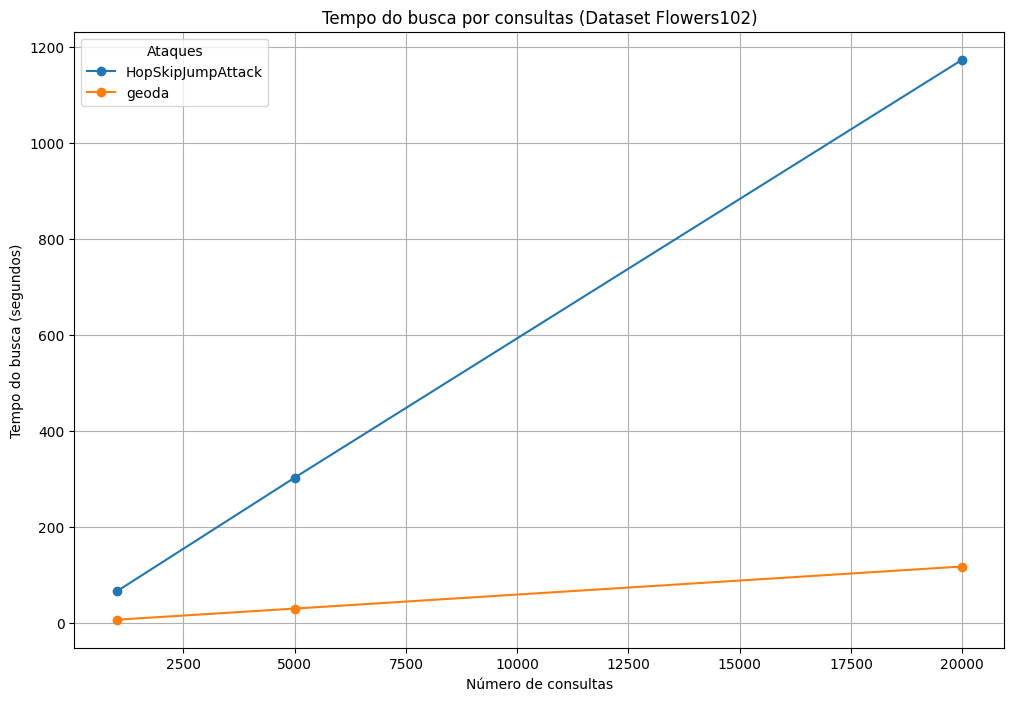

In [359]:

df_geoda = df[(df['dataset'] == 'Flowers102') & (df['distance'] == 'l2')]

grouped = df_geoda.groupby(['image', 'attack', 'query_max']).agg(time_sum=('time', 'sum')).reset_index()

grouped = grouped.groupby(['attack', 'query_max']).agg(time_sum=('time_sum', 'median')).reset_index()

print(grouped)

attacks = grouped['attack'].unique()
plt.figure(figsize=(12, 8))

for attack in attacks:
    subset = grouped[grouped['attack'] == attack]
    # Ordenando pelo 'query_max' para garantir uma linha contínua
    subset = subset.sort_values('query_max')
    plt.plot(subset['query_max'], subset['time_sum'], label=attack, marker='o')

plt.title('Tempo do busca por consultas (Dataset Flowers102)')
plt.xlabel('Número de consultas')
plt.ylabel('Tempo do busca (segundos)')
plt.legend(title='Ataques')
plt.grid(True)
plt.show()

              attack  query_max     norm_p
0  HopSkipJumpAttack       1000  10.416317
1  HopSkipJumpAttack       5000   3.388218
2  HopSkipJumpAttack      20000   2.036896
3              geoda       1000   7.462089
4              geoda       5000   3.442279
5              geoda      20000   2.087560


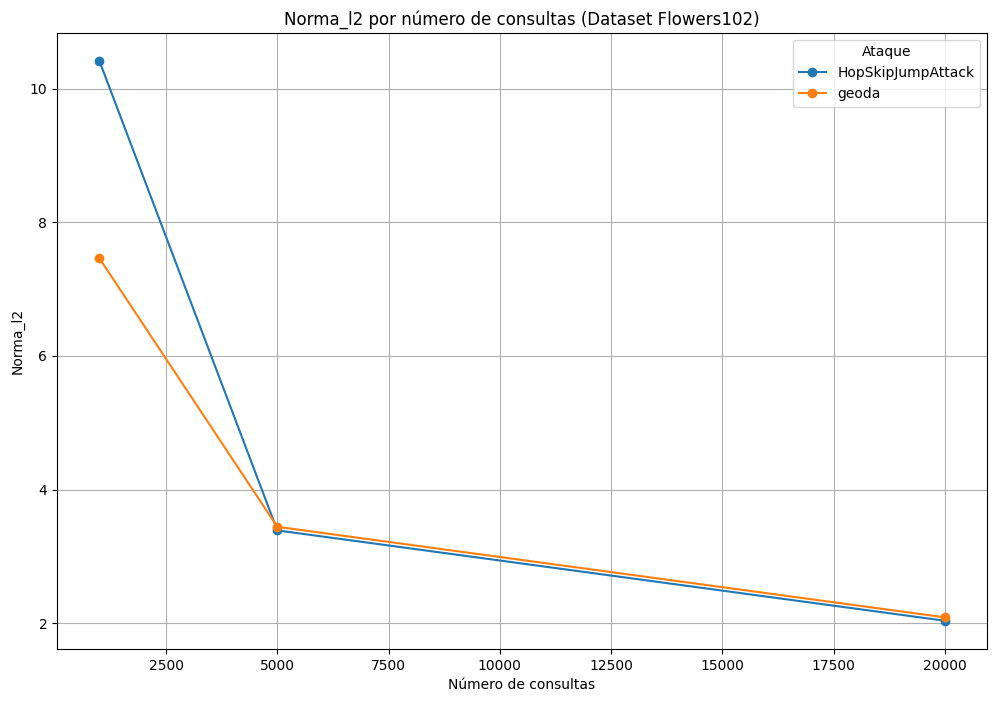

In [360]:

df_geoda = df[(df['dataset'] == 'Flowers102') & (df['distance'] == 'l2')]

grouped = df_geoda.groupby(['image', 'attack', 'query_max']).agg(norm_p=('norm_p', 'min')).reset_index()

grouped = grouped.groupby(['attack', 'query_max']).agg(norm_p=('norm_p', 'median')).reset_index()

print(grouped)

attacks = grouped['attack'].unique()
plt.figure(figsize=(12, 8))

for attack in attacks:
    subset = grouped[grouped['attack'] == attack]
    # Ordenando pelo 'query_max' para garantir uma linha contínua
    subset = subset.sort_values('query_max')
    plt.plot(subset['query_max'], subset['norm_p'], label=attack, marker='o')

plt.title('Norma_l2 por número de consultas (Dataset Flowers102)')
plt.xlabel('Número de consultas')
plt.ylabel('Norma_l2')
plt.legend(title='Ataque')
plt.grid(True)
plt.show()

In [342]:
df_geoda = df[(df['attack'] == 'geoda')]

grouped = df_geoda.groupby(['image', 'distance', 'attack', 'query_max']).agg(query_num=('query_num', 'max')).reset_index()

# Get count registers thar has query_num > query_max
print(grouped[grouped['query_num'] > grouped['query_max']].shape[0], grouped.shape[0], grouped[grouped['query_num'] > grouped['query_max']].shape[0] / grouped.shape[0])

1100 2937 0.37453183520599254
